<a href="https://colab.research.google.com/github/Jacob-Francis/SWSG_repo/blob/main/Colab_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [142]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [143]:
#!apt-get install cuda=10.2.89-1
# %matplotlib inline

# !pip install pykeops[colab] > install.log
# !pip install geomloss[full]
# !apt-get install ffmpeg

import torch
import numpy as np
from geomloss import SamplesLoss
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Device configuration
#pytorch.cuda.alloc.conf = expandable_segments
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)
# torch.set_default_device(device)

In [144]:
def Lloyds(f, N, k=10, Nsteps=3,scali=0.5, epsilon=0.01):

    # Generate initial grid of points for x
    grid_size = int(N**0.5)  # Assuming N is a perfect square
    x = (torch.rand(N, 2,device=device)).detach().requires_grad_(True) # Random points in [-1, 1]
    # Generate fine grid of points y with k*N points
    fine_grid_size = int((k * N)**0.5)
    y = torch.stack(torch.meshgrid(torch.linspace(0, 1, fine_grid_size,device=device),
                                   torch.linspace(0, 1, fine_grid_size,device=device)), dim=-1).reshape(-1, 2)
    y = y[:k * N]

    # Compute weights b proportional to f(y)
    b = f(y)
    b /= b.sum()  # Normalize to make b a probability distribution

    # Uniform weights for points x
    a = torch.full((N,), 1 / N,device=device)

    # Define the entropic OT loss function
    loss_fn = SamplesLoss("sinkhorn", p=2,scaling=scali, blur=epsilon**0.5)

    # Iterative Lloyd's algorithm
    for _ in range(Nsteps):
        # Compute the transport map between x and (y, b)
        loss = loss_fn(a,x,b, y)
        grad = torch.autograd.grad(loss, x)[0]
        x=x.clone().detach().requires_grad_(True)

        # Move points in the direction of the gradient to minimize OT cost
        with torch.no_grad():
            x -= N * grad  # Adjust x by moving in gradient direction

    return x.detach()  # Return points that fit the density function

def init_gaussian(N, k=10, epsilon=0.001,Nsteps=3,scali=0.99,std=[0.2,0.2]):
    def gaussian_density(points, mean=[0, 0], std=[0.1, 0.1]):
        """Evaluates a Gaussian function at given points."""
        dist = torch.distributions.MultivariateNormal(
            torch.tensor(mean,device=device),
            torch.diag(torch.tensor(std,device=device))**2
        )
        return torch.exp(dist.log_prob(points))
    # Run Lloyd's algorithm
    f = lambda y: gaussian_density(y, mean=[0.5, 0.5], std=[0.2, 0.2])  # Gaussian density function
    points = Lloyds(f, N, k=k, Nsteps=Nsteps, epsilon=epsilon)
    return points




In [145]:
# Parameters
N = 20
N1 = 20  # testing shapes
M = 100
epsilon = 0.01

# Generate G
# G = np.stack([j.flatten() for j in np.meshgrid(
#     np.linspace(1/(2*N), 1 - 1/(2*N), N, endpoint=True),
#     np.linspace(1/(2*N), 1 - 1/(2*N), N, endpoint=True))], axis=-1)
G = init_gaussian(N*N,std=[0.3,0.3])
G = torch.Tensor(G).requires_grad_(True)

# Generate X in the desired format (N * N, 2)
X = np.stack([j.flatten() for j in np.meshgrid(
    np.linspace(1/(2*N1), 1 - 1/(2*N1), N, endpoint=True),
    np.linspace(1/(2*N1), 1 - 1/(2*N1), N, endpoint=True))], axis=-1)

X = torch.Tensor(X).requires_grad_(True).type_as
# Generate Y in the desired format (M * M, 2)
Y = np.stack([j.flatten() for j in np.meshgrid(
    np.linspace(1/(2*M), 1 - 1/(2*M), M, endpoint=True),
    np.linspace(1/(2*M), 1 - 1/(2*M), M, endpoint=True))], axis=-1)
Y = torch.Tensor(Y).requires_grad_(True)


In [146]:
N = 100
M = 10*N 

debiase,scali,epsilon =False,0.99,0.001

#initialisations
grid_size = int(M ** 0.5)
grid = torch.linspace(0,1, grid_size)
y1, y2 = torch.meshgrid(grid, grid, indexing='ij')
Y = torch.stack([y1.flatten(), y2.flatten()], dim=1)[:M]

G = init_gaussian(N,std=[0.3,0.3])
Y = Y.type_as(G)
X = G.clone().requires_grad_(True)

R here is the reference measuer, though everything so far is just uniformly weighted by the number of points

In [147]:
loss = SamplesLoss('sinkhorn', p=2, blur=0.01)
lr = 0.1
sigma = 0.01


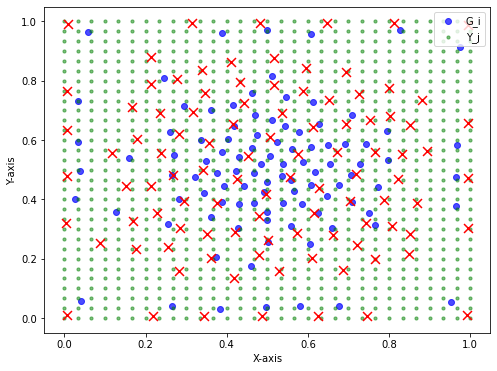

In [175]:
# solve one W2 (G, X)
L_gx = loss(G, X)
[h_gx] = torch.autograd.grad(L_gx, [X])
# solve W2 (X, Y)
L_xy = loss(X, Y)
[h_xy] = torch.autograd.grad(L_xy, [X])

# update X
update = h_gx + h_xy/sigma
X = X - lr*N*update / (1 + 1/sigma)

plt.figure(figsize=(8, 6))
plt.scatter(G[:, 0].cpu(), G[:, 1].cpu(), color='blue', label='G_i', alpha=0.7)
plt.scatter(Y[:, 0].cpu(), Y[:, 1].cpu(), color='green', s=10, label='Y_j', alpha=0.5)
plt.scatter(X[:, 0].detach().cpu(), X[:, 1].detach().cpu(), color='red', marker='x', s=80)
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [ ]:
# Dyanmics